# Research Methodology (Summary)

<p style="font-size: 2rem; background: #FFC000; color:#fff; padding: 2rem 4rem; border-radius:5px; text-align: center">
    Click on the button below to scroll to the <span style="font-weight: bold">Week 6 </span>section.</p>
    

<div style="display: flex; margin:4rem 0;">
    <div style="margin: 0 auto">
      <a type='button' href="#week4" style="border: 3px solid #ffc000; padding: 1rem 2rem; color: #ffc000; text-decoration: none; text-transform: uppercase; font-weight: bold">click here</a>
    </div>
</div>



In [77]:
from scipy.io import loadmat
from collections import namedtuple
from math import floor
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import antropy as ant
import pywt
import os
import seaborn as sns
import warnings

In [44]:
warnings.filterwarnings('ignore')
sns.set_theme()

<br/>

<div style="border: 2px solid #656565; border-radius: 5px; padding: 2rem 3rem;">
    <h1 style="margin: 0; color: #343d52">Model Building</h1>
</div>

## Selection of Relevant features

In [11]:
eeg_df = pd.read_csv("eeg_data.csv")
eeg_df.head()

,SampenCA_4,Katz_cA_4,Katz_cD_2,SampenCD_2,SampenCD_2D,SampenCA_4D,Katz_cA_4D,Katz_cD_2D,SampenCA_4DS,SampenCD_2DS,Katz_cA_4DS,Katz_DeltaDS,Katz_cD_1DS,Permen_cD_3DS,Permen_GammaDS,Permen_cD_1DS,Hig_cA_4DS,BIS
0,1.118584,2.579210,3.842405,1.589795,0.295259,0.376660,2.975620,2.220077,0.308904,0.176011,1.847512,1.891554,1.815630,0.992431,0.993749,0.997721,1.812455,95.8
1,1.108791,2.427762,3.855503,1.578562,0.317506,0.404385,2.945514,2.231705,0.319252,0.182602,1.855281,1.886988,1.818783,0.993881,0.993224,0.997555,1.812594,95.8
2,1.111692,2.581948,3.533784,1.567324,0.342623,0.442947,2.975240,2.239327,0.328542,0.187470,1.858956,1.888266,1.821905,0.994908,0.992231,0.997616,1.810743,95.8
3,1.122940,2.260806,3.837354,1.594337,0.371085,0.492027,2.976338,2.246107,0.340638,0.192986,1.862032,1.883636,1.823571,0.996844,0.991169,0.998204,1.810351,95.6
4,1.091586,2.301977,3.401760,1.622987,0.403649,0.552274,2.993204,2.251073,0.337477,0.196044,1.863008,1.882063,1.824643,0.998060,0.990647,0.998105,1.808214,95.6


<br/>

## Feature Selection and Multicollinearity

In [11]:
def correlation_matrix(df):    
    figure = plt.figure(figsize=(20, 20))
    cm = np.corrcoef(df[df.columns].values.T)
    sns.set(font_scale=1.5)

    # Heatmap
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt=".2f", annot_kws={'size' : 20}, yticklabels=df.columns, xticklabels=df.columns)

    plt.show()

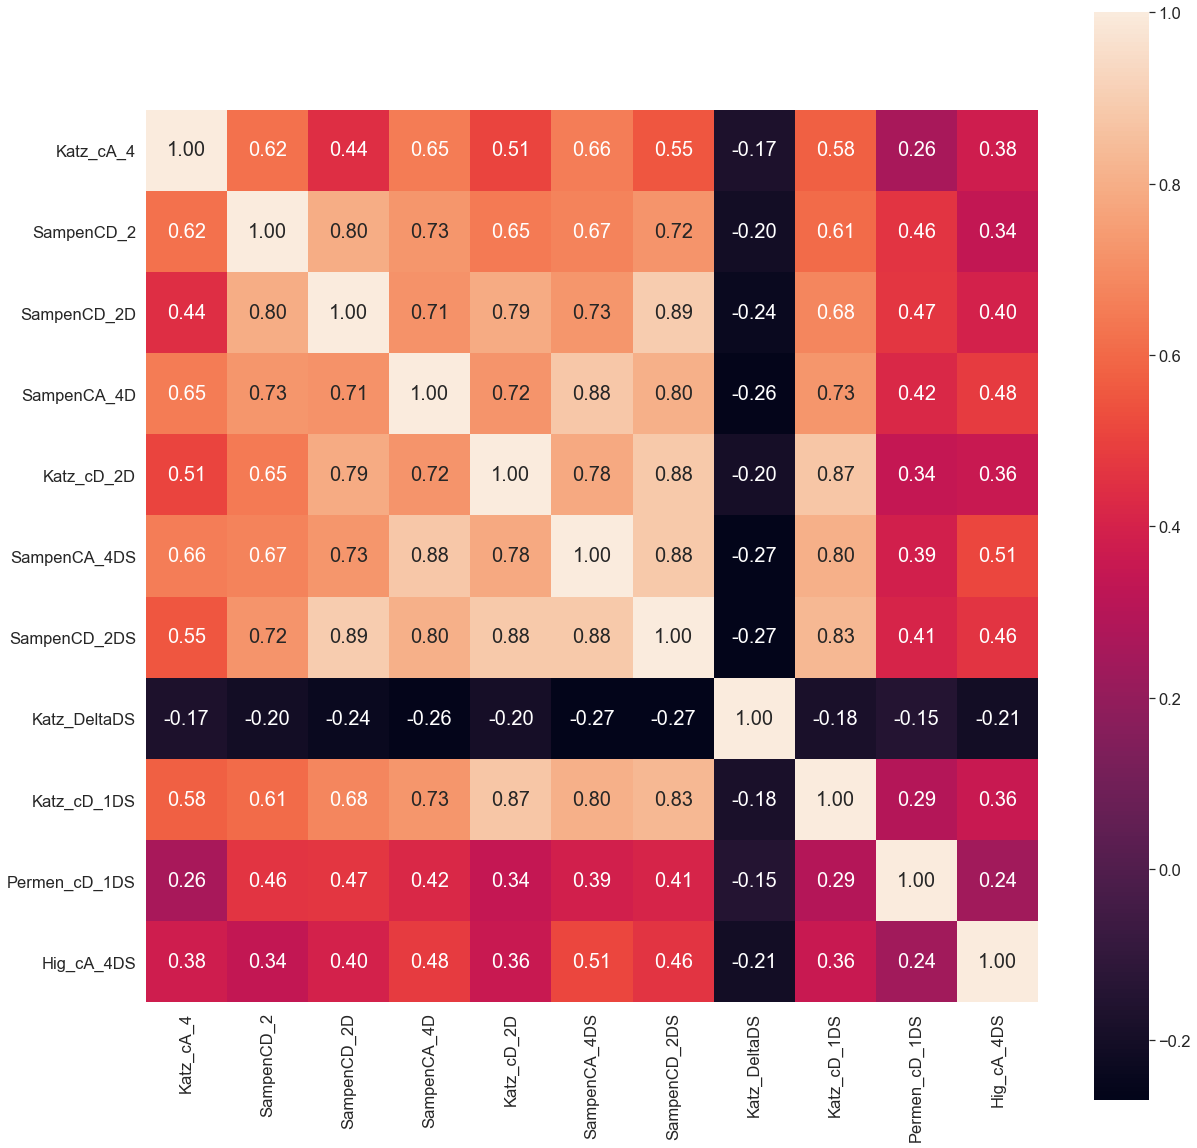

In [10]:
# Selected features
cols = ['Katz_cA_4', 'SampenCD_2', 'SampenCD_2D', 'SampenCA_4D', 'Katz_cD_2D', 'SampenCA_4DS', 'SampenCD_2DS', 'Katz_DeltaDS', 'Katz_cD_1DS', 'Permen_cD_1DS', 'Hig_cA_4DS']

# Checking for multicollinearity
correlation_matrix(eeg_df[cols])

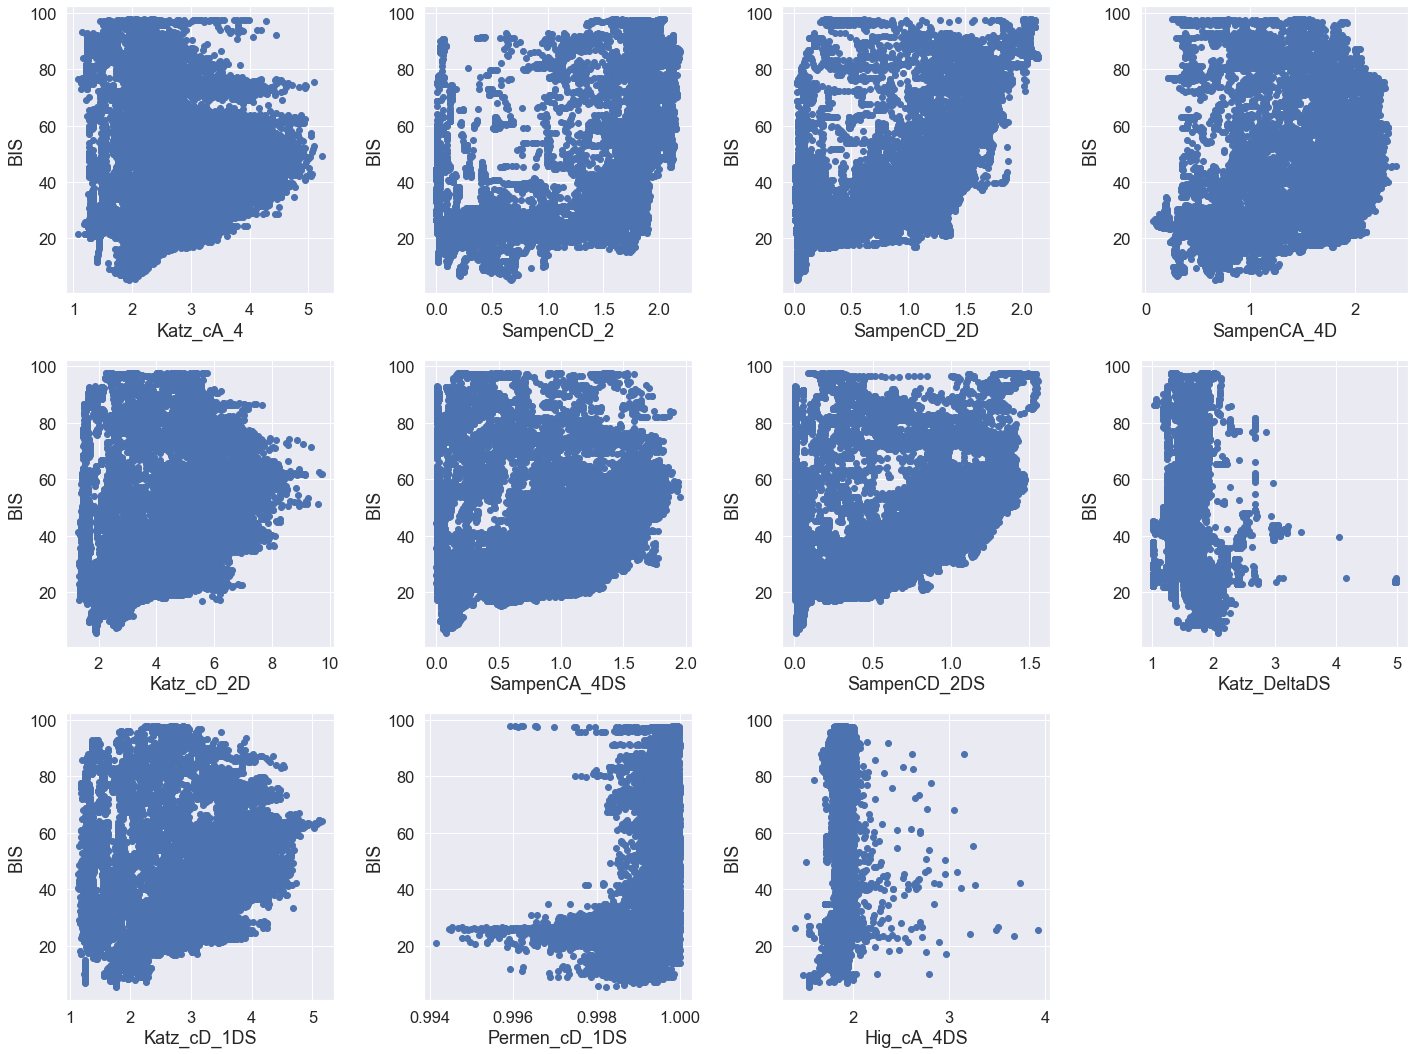

In [12]:
# Check the relationship between the selected features and the BIS
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

ax[2, 3].axis('off')

for idx, feature in enumerate(cols[:4]):
    ax[0, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[0, idx].set_ylabel('BIS')
    ax[0, idx].set_xlabel(feature)
    
for idx, feature in enumerate(cols[4:8]):
    ax[1, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[1, idx].set_ylabel('BIS')
    ax[1, idx].set_xlabel(feature)
    
for idx, feature in enumerate(cols[8:]):
    ax[2, idx].scatter(eeg_df[feature], eeg_df['BIS'])
    ax[2, idx].set_ylabel('BIS')
    ax[2, idx].set_xlabel(feature)
    
    
plt.tight_layout()
plt.show()

<br/>

## Model Building with Selected Features

In [12]:
selected_features = ['Katz_cA_4', 'SampenCD_2D', 'SampenCA_4D', 'Katz_cD_2D', 'SampenCA_4DS', 'SampenCD_2DS', 'Katz_DeltaDS', 'Katz_cD_1DS', 'Permen_cD_1DS', 'Hig_cA_4DS']

In [13]:
training_data = eeg_df[selected_features]

In [127]:
class model:
    
    my_model = None

    def __init__(self, model, data, scale):
        self.model = model
        self.data = data
        self.scale = scale
        
        
    def fit(self, features):
        X = self.data[features]
        y = self.data['BIS']
        
        if self.scale == True:
            scaled_X = StandardScaler()
            scaled_Y = StandardScaler()

            X = scaled_X.fit_transform(X)
            y = scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
        
        # Linear regression
        if self.model == 'lr':
            my_model = LinearRegression()
            my_model.fit(X, y)
                
            self.my_model = my_model
            print("Done training")
            
            
        # Decision tree
        if self.model == "tree":
            max_depth = 10
            my_model = DecisionTreeRegressor(max_depth=max_depth)
            my_model.fit(X, y)
            
            self.my_model = my_model
            print("Done training")
            
            
            
            
            
            
    def predict(self, test_data, features, visualize=True, evaluate=True):
        
        if self.my_model == None:
            raise Exception("Call the fit() method to train a model")
            
        X = test_data[features]
        y = test_data['BIS']
        xmin, xmax = 0, 110
        
        if self.scale == True:
            test_scaled_X = StandardScaler()
            test_scaled_Y = StandardScaler()
            
            X = test_scaled_X.fit_transform(X)
            y = test_scaled_Y.fit_transform(y[:, np.newaxis]).flatten()
            
            # For the residual plot
            xmin, xmax = -3, 3
            
            
        # Predict
        y_pred = self.my_model.predict(X)
            
        # Visualize after predicting    
        if visualize == True:
            figure = plt.figure(figsize=(15, 10))
            plt.plot(y, label="Actual BIS")
            plt.plot(y_pred, label="Predicted BIS")
            plt.xlabel('Samples')
            plt.ylabel('BIS')
            plt.legend(loc='upper left')
            plt.title("Depth of Anaesthesia assessment with EEG")
            plt.show()
            
            
        if evaluate == True:
            # Residual plot
            figure = plt.figure(figsize=(15, 10))
            plt.scatter(y_pred, y_pred - y, c='royalblue', marker='o',  edgecolor='white')
            plt.ylabel("Residuals")
            plt.xlabel("Predicted Values")
            plt.hlines(y=0, xmin=xmin, xmax=xmax, color='black', lw=2)
            plt.xlim([xmin, xmax])
            plt.show()
            
            
            # MSE and R^2
            mse = mean_squared_error(y, y_pred)
            
            print("MSE: %.3f" % mse)

                
                
        
            

In [128]:
# Testing a linear regression model
test_model = model('lr', eeg_df, scale=False)

test_model.fit(selected_features)

Done training


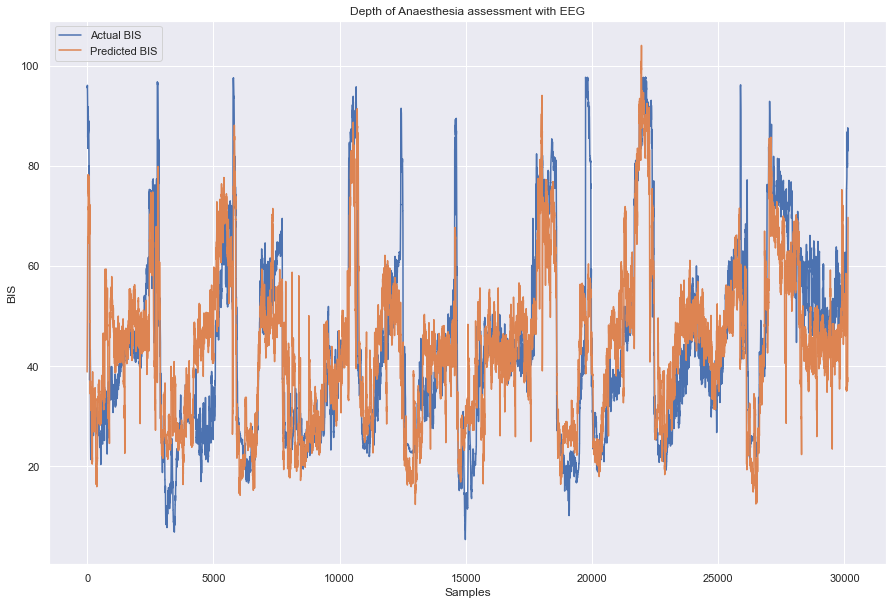

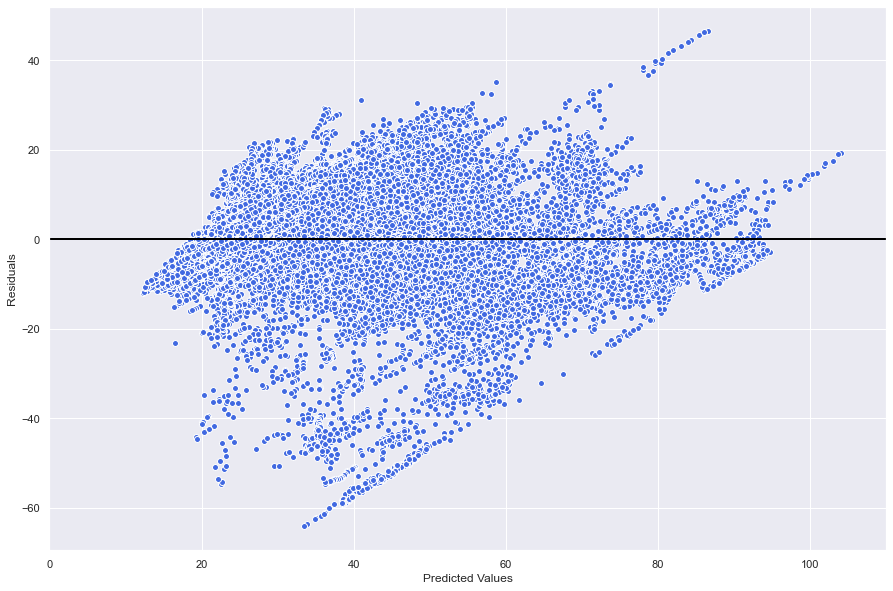

MSE: 144.060


In [114]:
test_model.predict(eeg_df, selected_features)

<br/>

<br/>

## <code>create_patient_data</code>

Get the data of each patient

In [117]:
def create_patient_data(patient):    
    folders = ["Katz_CH2Squared", "SampEntropy", "Katz", "SampEntropy_CH2DenoisedSquared", "Katz_CH2DenoisedSquared", "PermEntropy_CH2DenoisedSquared", "Higuchi_CH2DenoisedSquared"]
    patient_dict = {}

    for folder in folders:
        df = pd.read_csv("./Class A train sets/{}/Modified/{}".format(folder, patient))

        patient_dict['BIS'] = df['BIS']

        # CH2^2 Folder
        if folder == "Katz_CH2Squared":
            patient_dict['Katz_cA_4'] = df['Katz_cA_4']

        # CH2Denoised Folders
        if folder ==  "SampEntropy":
            patient_dict['SampenCD_2D'] = df['SampenCD_2']
            patient_dict['SampenCA_4D'] = df['SampenCA_4']


        if folder ==  "Katz":
            patient_dict['Katz_cD_2D'] = df['Katz_cD_2']


        # CH2DenoisedSquared Folders
        if folder == "SampEntropy_CH2DenoisedSquared":
            patient_dict['SampenCA_4DS'] = df['SampenCA_4']
            patient_dict['SampenCD_2DS'] = df['SampenCD_2']


        if folder == "Katz_CH2DenoisedSquared":
            patient_dict['Katz_DeltaDS'] = df['Katz_Delta']
            patient_dict['Katz_cD_1DS'] = df['Katz_cD_1']


        if folder == "PermEntropy_CH2DenoisedSquared":
            patient_dict['Permen_cD_1DS'] = df['Permen_cD_1']


        if folder == "Higuchi_CH2DenoisedSquared":
            patient_dict['Hig_cA_4DS'] = df['Hig_cA_4']
            
            
    patient_dataset = pd.DataFrame(patient_dict)
    
    return patient_dataset

In [118]:
# Test the create_patient_data() function
test_patient = create_patient_data("13_EEG20100609.mat_modified.csv")

In [119]:
test_patient.head()

,BIS,Katz_cA_4,SampenCD_2D,SampenCA_4D,Katz_cD_2D,SampenCA_4DS,SampenCD_2DS,Katz_DeltaDS,Katz_cD_1DS,Permen_cD_1DS,Hig_cA_4DS
0,59.2,1.784283,0.133905,0.348438,1.898219,0.319543,0.086307,1.586529,1.634744,0.999541,1.858706
1,59.0,1.727093,0.135432,0.368834,1.900659,0.317834,0.086301,1.585038,1.634863,0.999511,1.859619
2,37.3,1.876292,0.126914,0.405924,1.975516,0.333829,0.091123,1.582784,1.656698,0.999463,1.861839
3,37.3,1.851609,0.132459,0.454419,1.996951,0.353303,0.100822,1.590751,1.661420,0.999213,1.865707
4,37.3,1.785929,0.140863,0.506331,2.010299,0.358351,0.105007,1.581439,1.662818,0.999485,1.863204


<br/>

## Patient files

In [125]:
# Training set (The patients)
training_set = [file+'_modified.csv' for file in os.listdir("./Class A train sets") if ".mat" in file]

<br/>

## <code>LinearRegression</code>

In [130]:
# Create a linear regression model using the entire training dataset
lr = model('lr', eeg_df, scale=False)

# Train the model
lr.fit(selected_features)

Done training


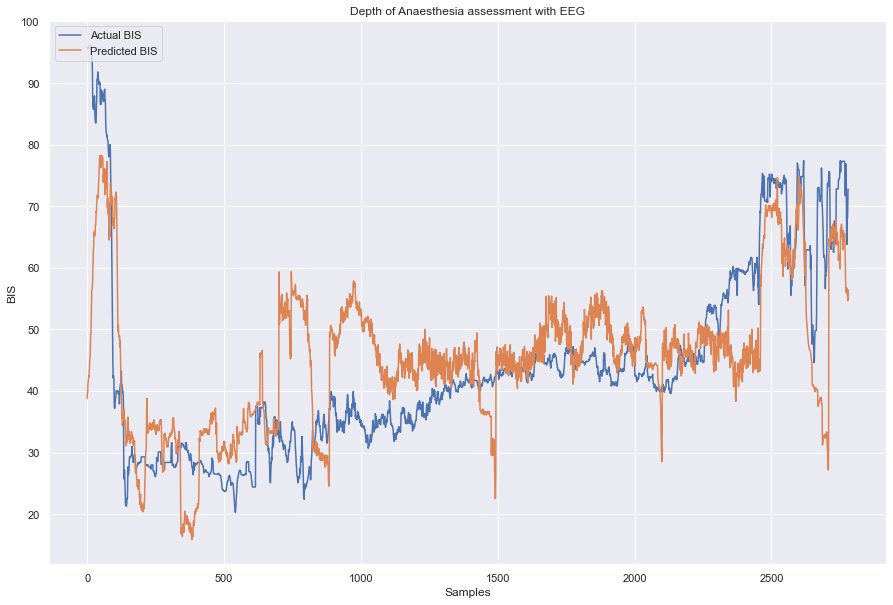

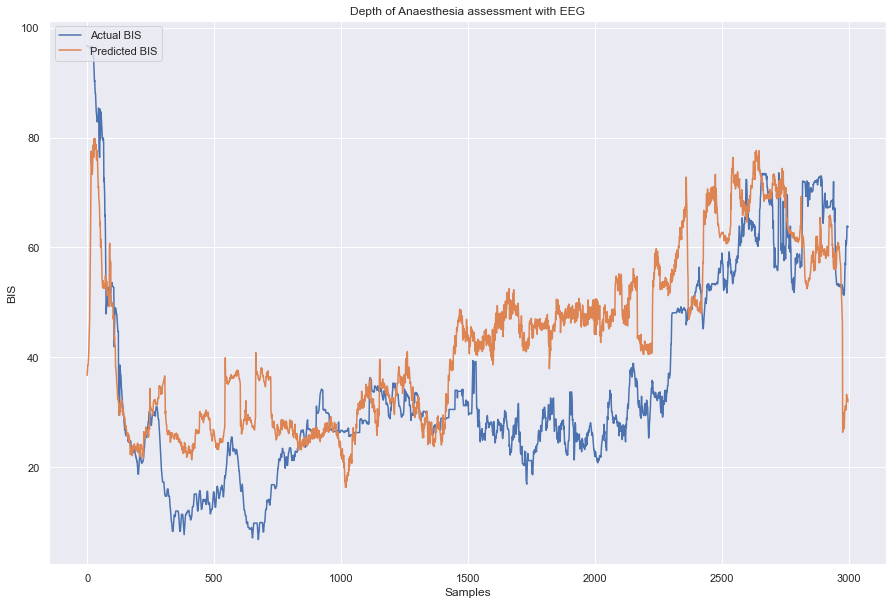

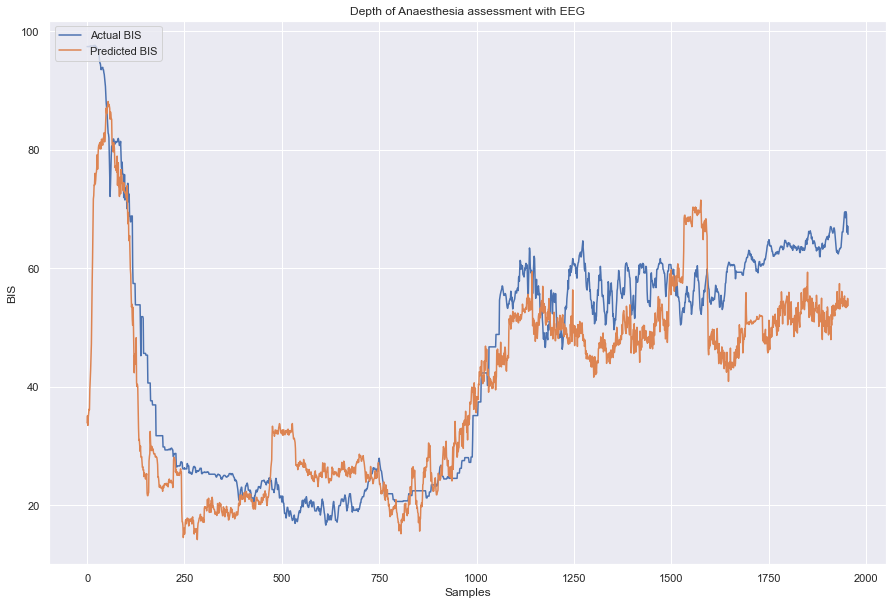

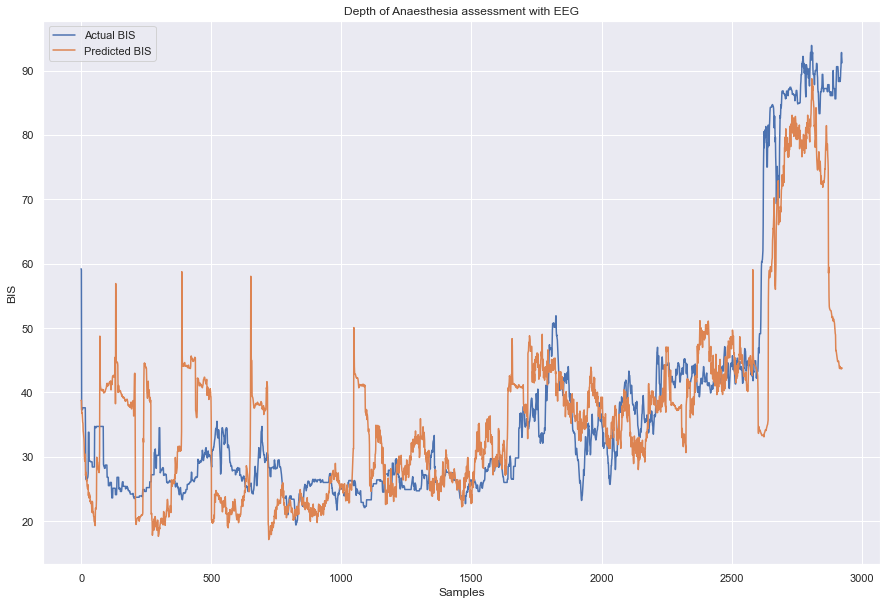

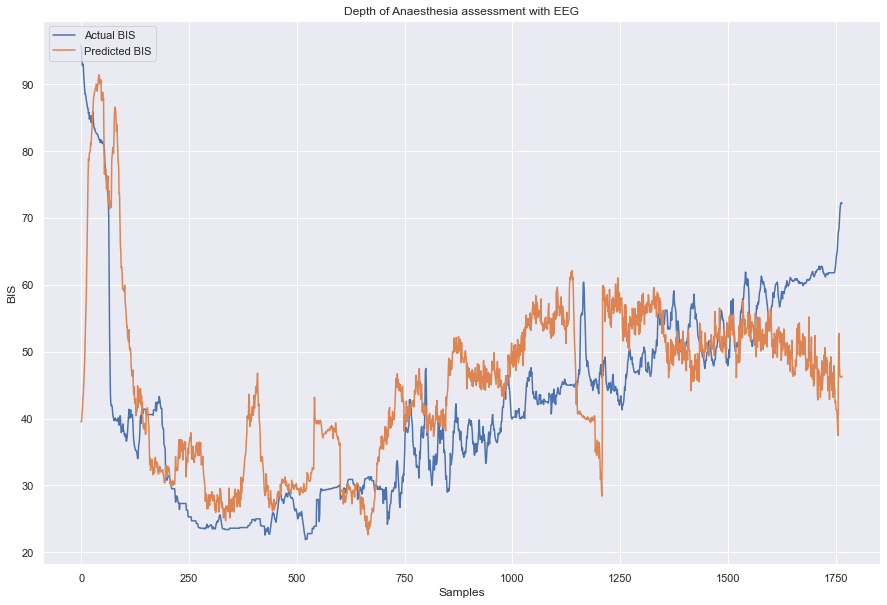

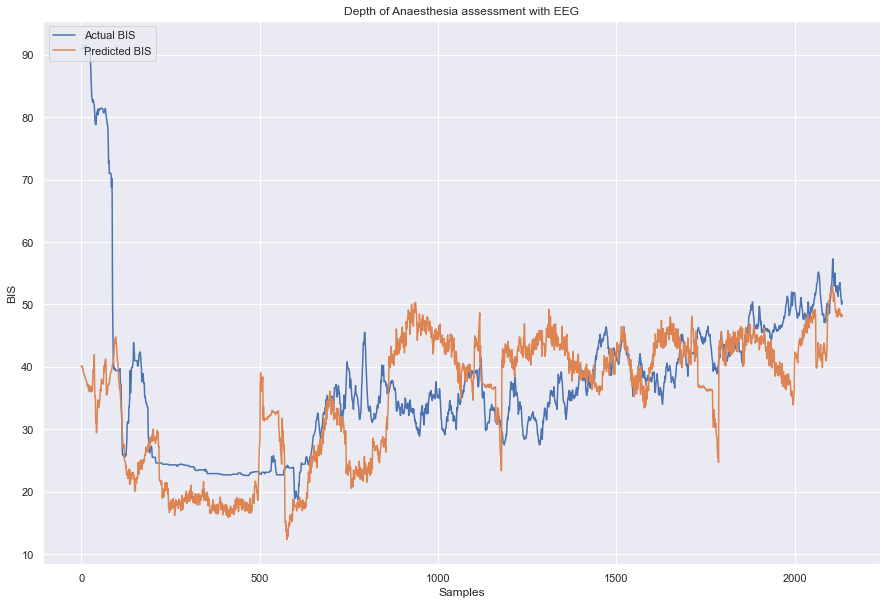

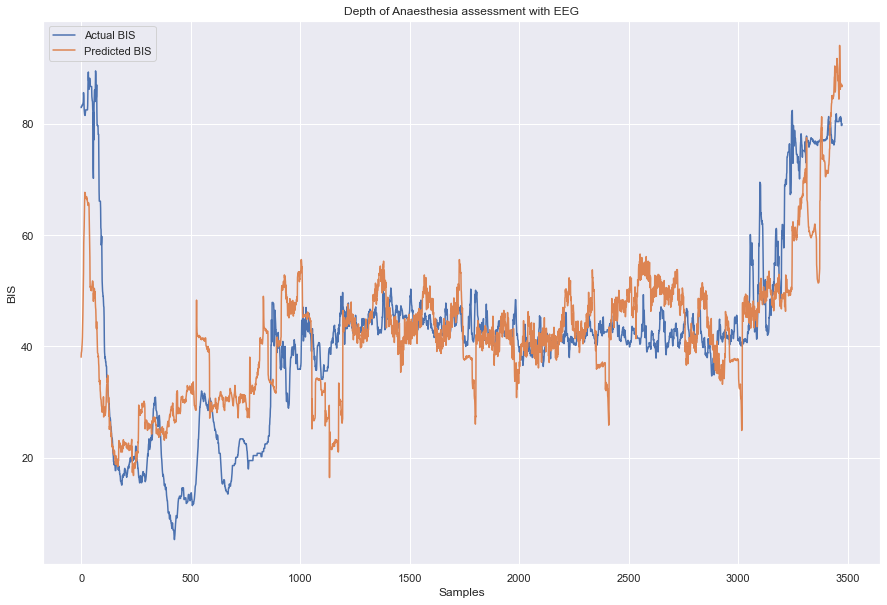

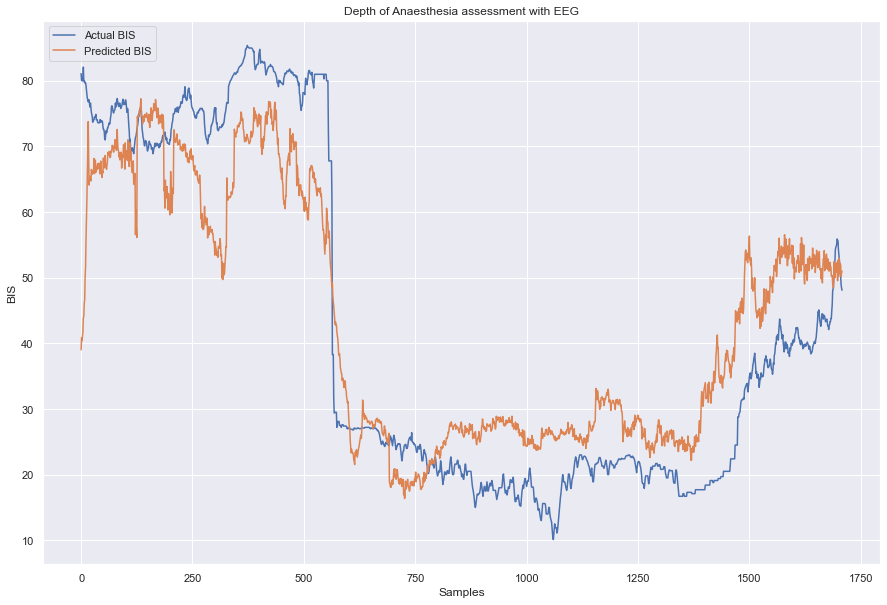

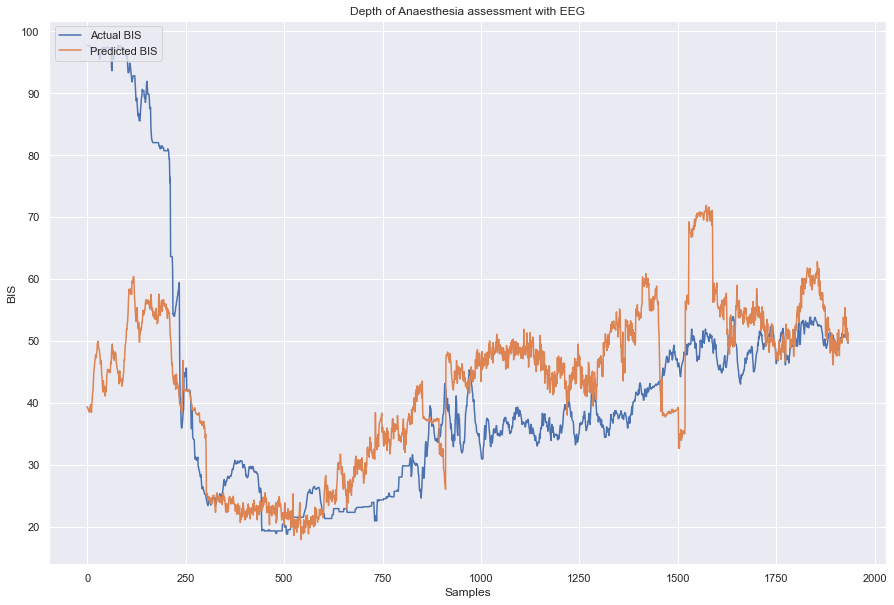

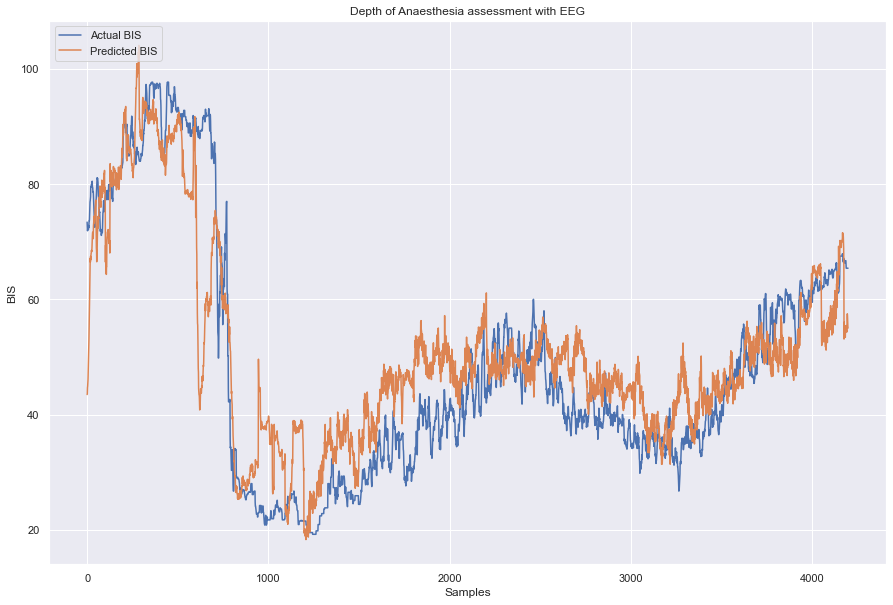

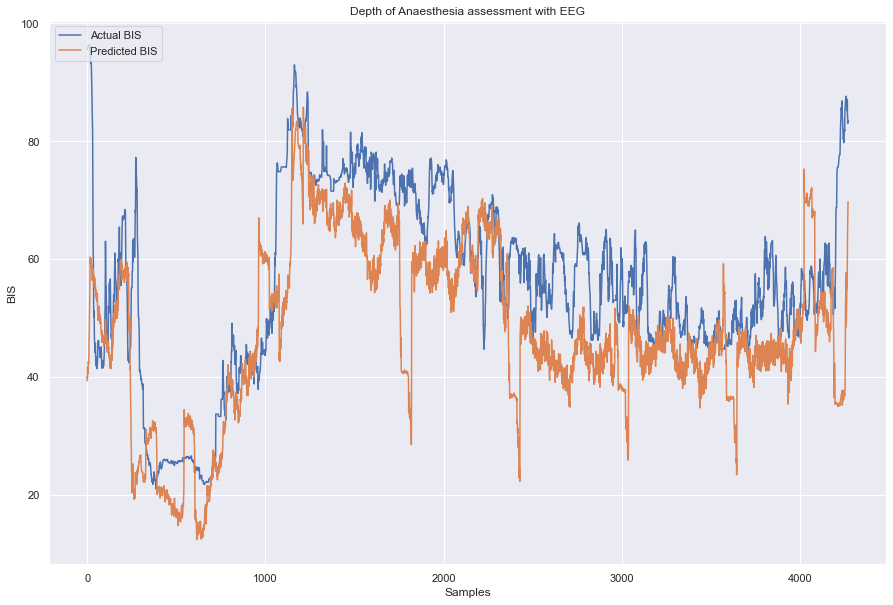

In [131]:
for train in training_set:
    patient = create_patient_data(train)
    lr.predict(patient, selected_features, evaluate=False)

<br/>

## <code>Decision Tree Regression</code>

In [132]:
# Create a linear regression model using the entire training dataset
tree = model('tree', eeg_df, scale=False)

# Train the model
tree.fit(selected_features)

Done training


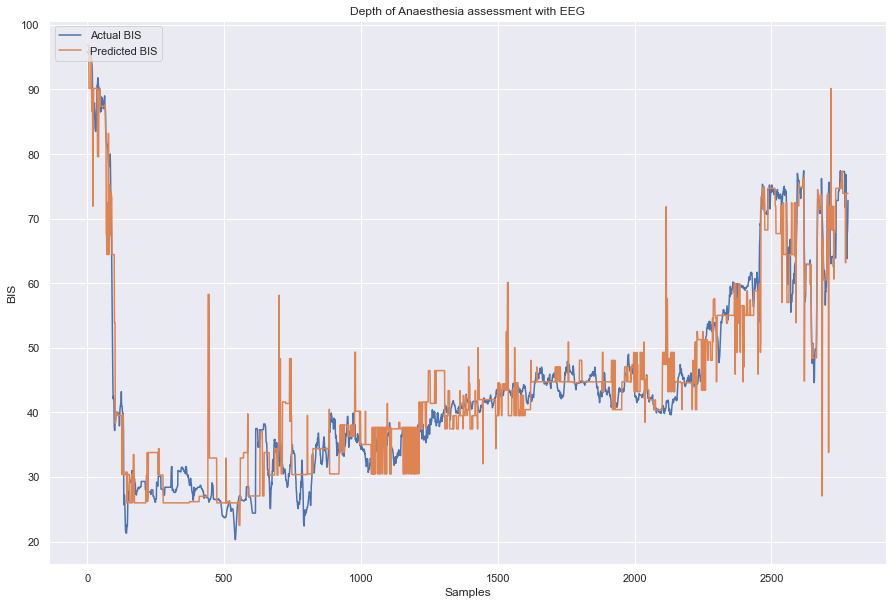

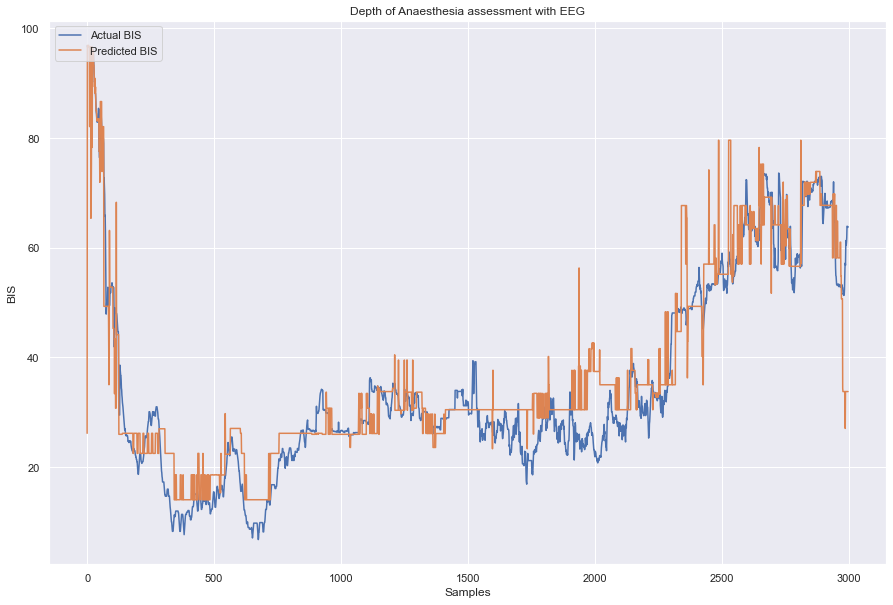

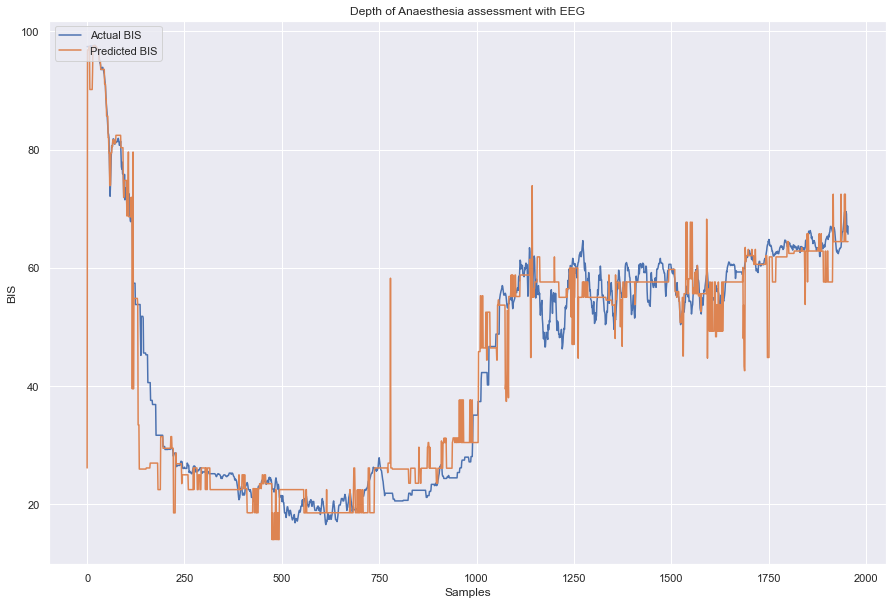

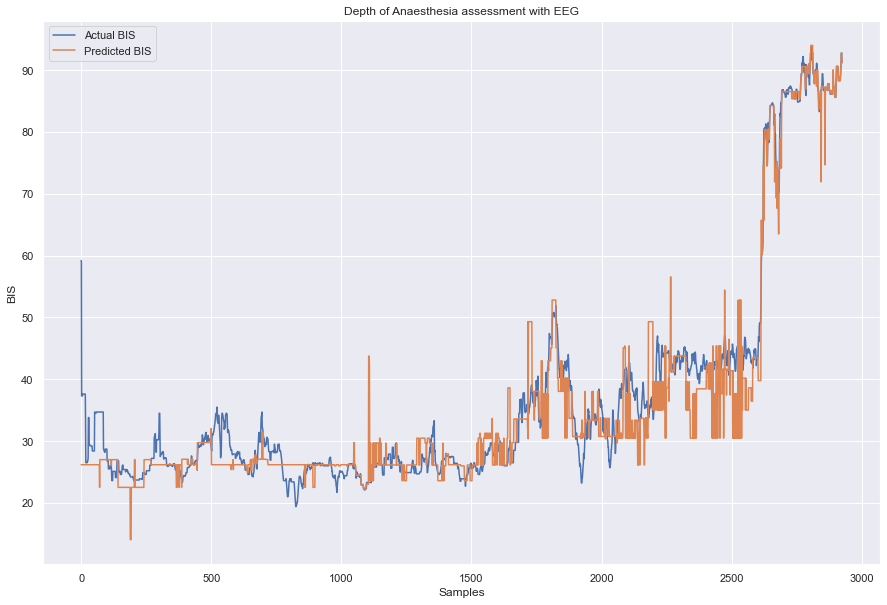

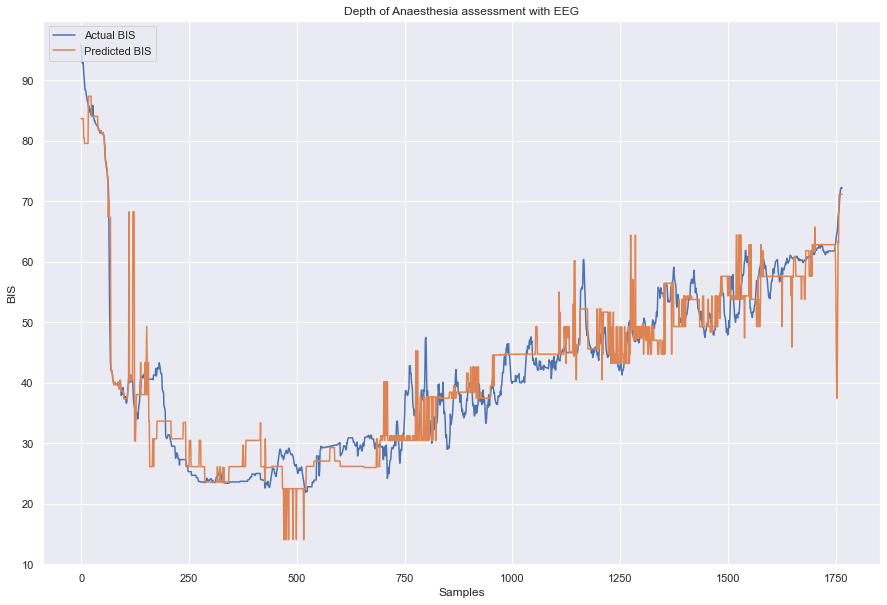

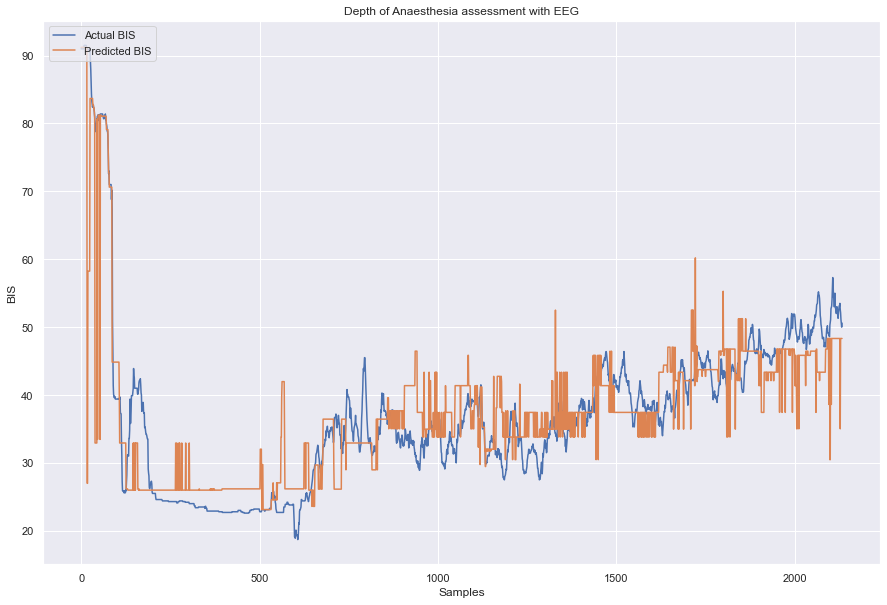

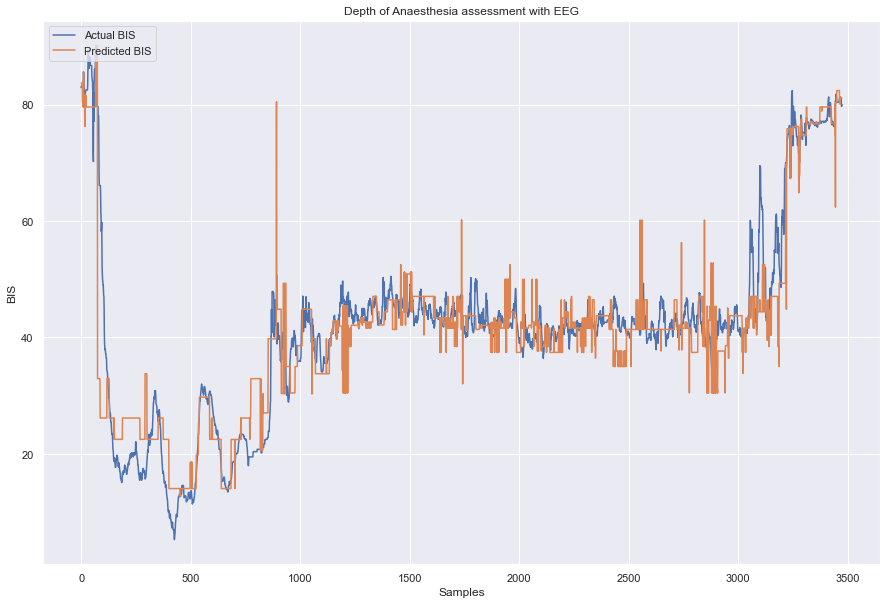

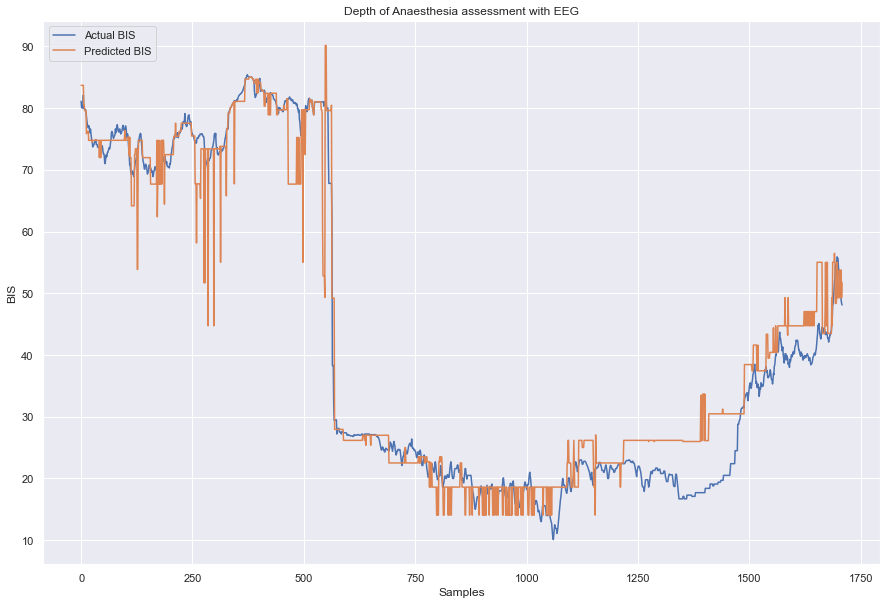

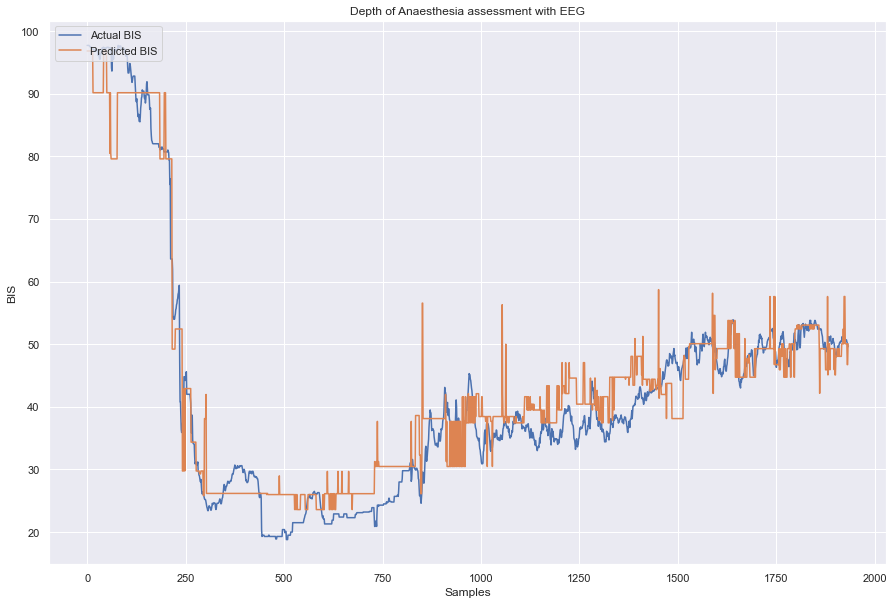

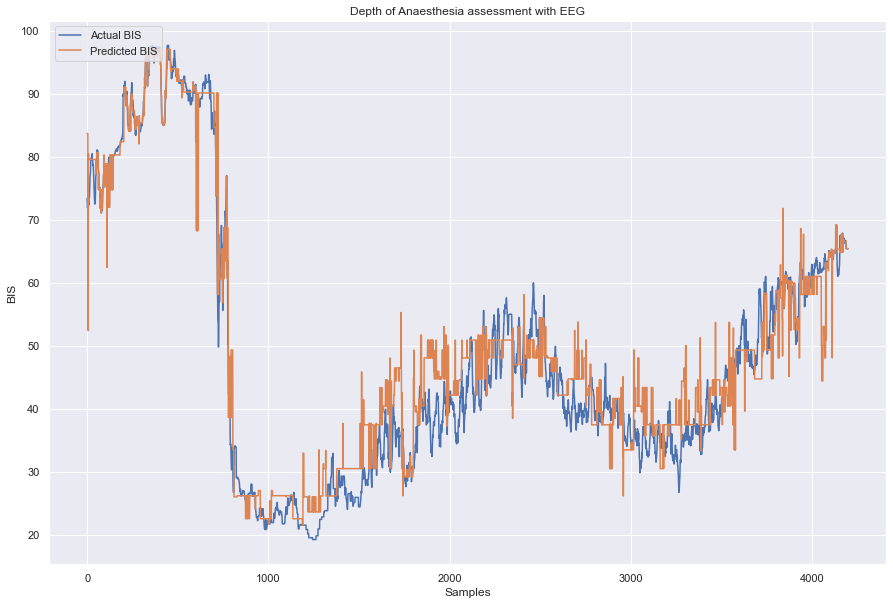

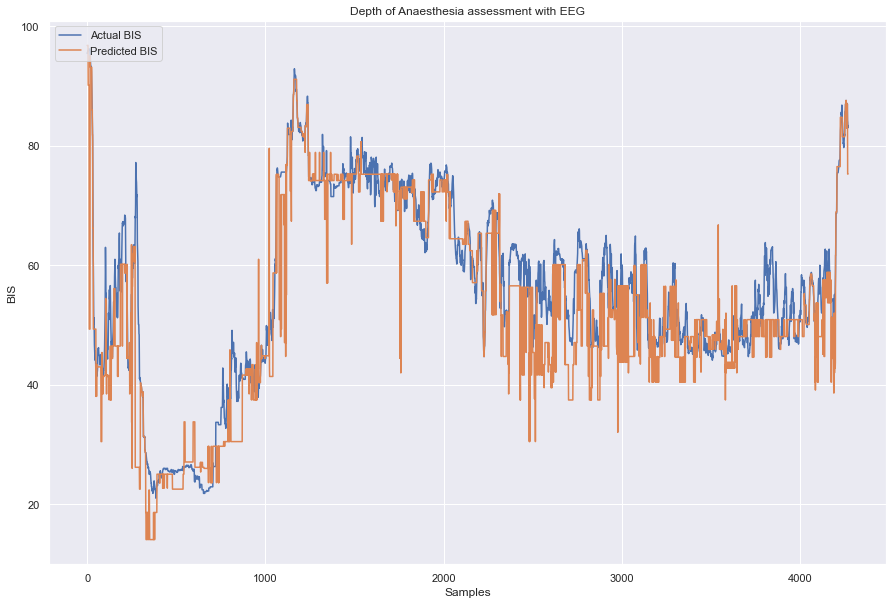

In [133]:
for train in training_set:
    patient = create_patient_data(train)
    tree.predict(patient, selected_features, evaluate=False)

<br/>